In [1]:
#General libraries
import os
import pandas as pd
import numpy as np

#Graph tools
import matplotlib.pyplot as plt 
import seaborn as sns

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer, KNNImputer
from imblearn.under_sampling import RandomUnderSampler

from lightgbm import LGBMClassifier

from boruta import BorutaPy

#Optimization
import optuna

#Experiment tracking
import mlflow

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_path = os.path.join('data', 'train.csv')
train_extra_path = os.path.join('data', 'train_extra.csv')
test_path = os.path.join('data', 'test.csv')
sample_submission_path = os.path.join('data', 'sample_submission.csv')

raw_train_data = pd.read_csv(train_path, index_col= 'id')
train_extra = pd.read_csv(train_extra_path)
train_extra['rainfall'] = train_extra['rainfall'].map({'yes': 1, 'no': 0})
ord_cols = raw_train_data.columns
train_extra.columns = train_extra.columns.str.strip()
train_extra = train_extra[ord_cols]

raw_train_data = pd.concat([raw_train_data, train_extra], ignore_index=True)
raw_train_data.dropna(inplace= True)

raw_test_data = pd.read_csv(test_path, index_col = 'id')
sample_submission = pd.read_csv(sample_submission_path)

raw_train_data.drop_duplicates(inplace= True)

In [3]:
raw_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2555 entries, 0 to 2555
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            2555 non-null   int64  
 1   pressure       2555 non-null   float64
 2   maxtemp        2555 non-null   float64
 3   temparature    2555 non-null   float64
 4   mintemp        2555 non-null   float64
 5   dewpoint       2555 non-null   float64
 6   humidity       2555 non-null   float64
 7   cloud          2555 non-null   float64
 8   sunshine       2555 non-null   float64
 9   winddirection  2555 non-null   float64
 10  windspeed      2555 non-null   float64
 11  rainfall       2555 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 259.5 KB


In [4]:
print(raw_train_data.shape)
raw_train_data.head()

(2555, 12)


,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


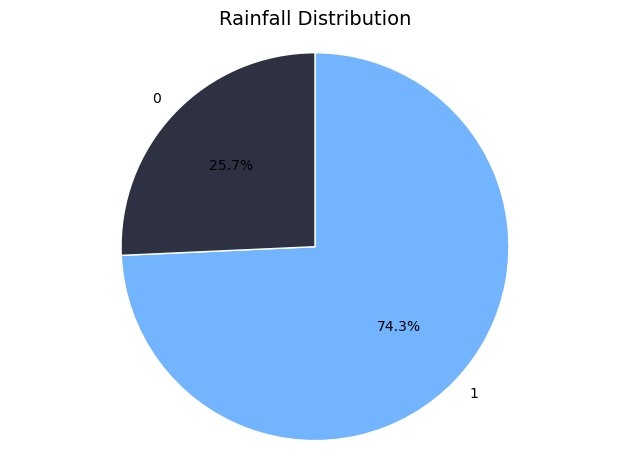

In [5]:
colors = ['#73B4FF', '#2D3142']
value_counts = raw_train_data['rainfall'].value_counts(normalize= True)
labels = value_counts.index.astype(str)
sizes = value_counts.values
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=90, 
    counterclock=False,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1},
    colors= colors
)
ax.axis('equal')

# Agregar título
ax.set_title('Rainfall Distribution', fontsize=14)

plt.tight_layout()
plt.show()

In [6]:
raw_train_data.skew()

day              0.211569
pressure         0.295777
maxtemp         -0.498073
temparature     -0.572202
mintemp         -0.665021
dewpoint        -1.017435
humidity        -0.745531
cloud           -1.314520
sunshine         0.600403
winddirection    0.721490
windspeed        0.769942
rainfall        -1.111978
dtype: float64

In [7]:
def data_preproccesing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    df['temp_change'] = df['maxtemp']-df['mintemp']
    df['temp_ratio'] = df['maxtemp']/df['mintemp']
    df['wind_dir_rad'] = np.deg2rad(df['winddirection'])
    df['wind_direction_sin'] = np.sin(df['wind_dir_rad'])
    df['wind_direction_cos'] = np.cos(df['wind_dir_rad'])
    df['avg_temp'] = (df['maxtemp'] + df['mintemp']) / 2
    df['dewpoint_depression'] = df['temparature'] - df['dewpoint']
    df['sunshine_ratio'] = df['sunshine'] / (1 + df['cloud'])
    df['cloud'] = np.log1p(df['cloud'])

    df.drop(columns=['winddirection'], inplace=True)
    
    #df_imputed = imputer.fit_transform(df)
    #df = pd.DataFrame(df_imputed, columns= df.columns)

    for col in df.columns:
        df[col +'_cat'] = df[col].astype(str)
        df[col +'_cat'] = df[col + '_cat'].astype('category')

    return df

def test_data_preproccesing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    df['temp_change'] = df['maxtemp']-df['mintemp']
    df['temp_ratio'] = df['maxtemp']/df['mintemp']
    df['wind_dir_rad'] = np.deg2rad(df['winddirection'])
    df['wind_direction_sin'] = np.sin(df['wind_dir_rad'])
    df['wind_direction_cos'] = np.cos(df['wind_dir_rad'])
    df['avg_temp'] = (df['maxtemp'] + df['mintemp']) / 2
    df['dewpoint_depression'] = df['temparature'] - df['dewpoint']
    df['sunshine_ratio'] = df['sunshine'] / (1 + df['cloud'])
    df['cloud'] = np.log1p(df['cloud'])

    df.drop(columns=['winddirection'], inplace=True)
    
    #df_imputed = imputer.transform(df)
    #df = pd.DataFrame(df_imputed, columns= df.columns)
    
    for col in df.columns:
        df[col +'_cat'] = df[col].astype(str)
        df[col +'_cat'] = df[col + '_cat'].astype('category')

    return df

In [8]:
X_train = raw_train_data.drop(columns= 'rainfall')
y_train = raw_train_data['rainfall']
X_train = data_preproccesing(X_train) 

In [9]:
X_train

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,windspeed,...,sunshine_cat,windspeed_cat,temp_change_cat,temp_ratio_cat,wind_dir_rad_cat,wind_direction_sin_cat,wind_direction_cos_cat,avg_temp_cat,dewpoint_depression_cat,sunshine_ratio_cat
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,4.488636,1.1,17.2,...,1.1,17.2,1.3000000000000007,1.065326633165829,1.0471975511965976,0.8660254037844386,0.5000000000000001,20.549999999999997,1.2000000000000028,0.012359550561797755
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,4.521789,0.0,21.9,...,0.0,21.9,0.3999999999999986,1.0253164556962024,0.8726646259971648,0.766044443118978,0.6427876096865394,16.0,1.4999999999999982,0.0
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,3.871201,8.3,18.1,...,8.3,18.1,4.799999999999999,1.3287671232876712,1.2217304763960306,0.9396926207859083,0.3420201433256688,17.0,6.800000000000001,0.1729166666666667
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,4.564348,0.0,35.6,...,0.0,35.6,1.2000000000000028,1.0710059171597635,1.0471975511965976,0.8660254037844386,0.5000000000000001,17.5,1.0,0.0
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,3.828641,3.6,24.8,...,3.6,24.8,6.100000000000001,1.4013157894736843,0.6981317007977318,0.6427876096865393,0.766044443118978,18.25,8.799999999999999,0.0782608695652174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2551,27,1022.7,18.8,17.7,16.9,15.0,84.0,4.510860,0.0,18.4,...,0.0,18.4,1.9000000000000021,1.1124260355029587,0.5235987755982988,0.49999999999999994,0.8660254037844387,17.85,2.6999999999999993,0.0
2552,28,1026.6,18.6,17.3,16.3,12.8,75.0,4.454347,1.0,25.9,...,1.0,25.9,2.3000000000000007,1.1411042944785277,0.3490658503988659,0.3420201433256687,0.9396926207859084,17.450000000000003,4.5,0.011627906976744186
2553,29,1025.9,18.9,17.7,16.4,13.3,75.0,4.369448,4.6,33.4,...,4.6,33.4,2.5,1.1524390243902438,1.2217304763960306,0.9396926207859083,0.3420201433256688,17.65,4.399999999999999,0.05822784810126582
2554,30,1025.3,19.2,17.3,15.2,13.3,78.0,4.465908,1.2,20.9,...,1.2,20.9,4.0,1.263157894736842,0.3490658503988659,0.3420201433256687,0.9396926207859084,17.2,4.0,0.013793103448275862


In [22]:

def objective(trial, X, y):
    # Definición de hiperparámetros para LightGBM
    params = {
        'objective': 'binary',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log= True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log= True),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log= True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log= True),
        'n_estimators': trial.suggest_int('n_estimators', 25, 125),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0001, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 10),
        'max_bin': trial.suggest_int('max_bin', 100, 300),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 2.0),
        'random_state': 42,
        'verbosity': -1
    }
    # Creación del clasificador LightGBM con los parámetros sugeridos
    clf = LGBMClassifier(**params)
    
    # Utilizamos StratifiedKFold para mantener el balance de clases (5 particiones)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_scores = []
    val_scores = []
    
    with mlflow.start_run():
        for fold, (train_idx, val_idx) in enumerate(skf.split(X,y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            boruta_selector = BorutaPy(clf, n_estimators= 'auto', random_state= 42)
            boruta_selector.fit(X_train, y_train)

            X_train_selected = boruta_selector.transform(X_train.values)
            X_val_selected = boruta_selector.transform(X_val.values)

            if X_train_selected.shape[1] == 0:
                print(f"Fold {fold} skipped due to no features selected by Boruta.")
                continue

            clf.fit(X_train_selected, y_train)
            train_proba = clf.predict_proba(X_train_selected)[:, 1]
            val_proba = clf.predict_proba(X_val_selected)[:, 1]

            train_auc = roc_auc_score(y_train, train_proba)
            val_auc = roc_auc_score(y_val, val_proba)

            train_scores.append(train_auc)
            val_scores.append(val_auc)

            mlflow.log_metric(f"train_auc_fold_{fold}", train_auc)
            mlflow.log_metric(f"val_auc_fold_{fold}", val_auc)

        avg_train_auc = np.mean(train_scores)
        avg_val_auc = np.mean(val_scores)

        mlflow.log_params(params)
        mlflow.log_metric("avg_train_auc", avg_train_auc)
        mlflow.log_metric("avg_val_auc", avg_val_auc)

        print(f"Trial {trial.number} - Avg Train AUC: {avg_train_auc:.4f} | Avg Validation AUC: {avg_val_auc:.4f}")

    return avg_val_auc


In [23]:
study = optuna.create_study(direction='maximize', sampler= optuna.samplers.TPESampler(seed= 42))
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100)

[I 2025-03-17 19:14:00,426] A new study created in memory with name: no-name-b59c696c-5ba3-4e51-a3f4-2cac271d5417
[I 2025-03-17 19:15:25,949] Trial 0 finished with value: 0.8879595148693429 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.029106359131330698, 'num_leaves': 188, 'max_depth': 3, 'min_child_samples': 19, 'min_child_weight': 0.0017073967431528124, 'subsample': 0.9197056874649611, 'colsample_bytree': 0.7606690070459253, 'reg_alpha': 0.02358594058414266, 'reg_lambda': 1.5320059381854043e-08, 'n_estimators': 122, 'min_split_gain': 0.8324593965363417, 'subsample_freq': 2, 'max_bin': 136, 'scale_pos_weight': 0.7751067647801507}. Best is trial 0 with value: 0.8879595148693429.


Trial 0 - Avg Train AUC: 0.9100 | Avg Validation AUC: 0.8880


[I 2025-03-17 19:16:58,726] Trial 1 finished with value: 0.8853731398564655 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.007309539835912915, 'num_leaves': 101, 'max_depth': 6, 'min_child_samples': 18, 'min_child_weight': 0.01474275315991467, 'subsample': 0.6198171059762151, 'colsample_bytree': 0.6736419905302216, 'reg_alpha': 0.11656915613247415, 'reg_lambda': 6.267062696005991e-07, 'n_estimators': 76, 'min_split_gain': 0.5924553274051563, 'subsample_freq': 0, 'max_bin': 222, 'scale_pos_weight': 0.7557861855309373}. Best is trial 0 with value: 0.8879595148693429.


Trial 1 - Avg Train AUC: 0.9268 | Avg Validation AUC: 0.8854


[I 2025-03-17 19:18:01,652] Trial 2 finished with value: 0.8837293021894078 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.08536189862866832, 'num_leaves': 247, 'max_depth': 4, 'min_child_samples': 14, 'min_child_weight': 0.5456725485601478, 'subsample': 0.6640914962437608, 'colsample_bytree': 0.47322294090686734, 'reg_alpha': 0.00028614897264046574, 'reg_lambda': 2.039373116525212e-08, 'n_estimators': 116, 'min_split_gain': 0.2588541036018569, 'subsample_freq': 7, 'max_bin': 162, 'scale_pos_weight': 1.2801020317667162}. Best is trial 0 with value: 0.8879595148693429.


Trial 2 - Avg Train AUC: 0.9197 | Avg Validation AUC: 0.8837


[I 2025-03-17 19:18:27,366] Trial 3 finished with value: 0.8738076958140886 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.08692991511139551, 'num_leaves': 237, 'max_depth': 8, 'min_child_samples': 90, 'min_child_weight': 0.24637685958997463, 'subsample': 0.9531245410138701, 'colsample_bytree': 0.4530955012311517, 'reg_alpha': 5.805581976088804e-07, 'reg_lambda': 2.5529693461039728e-08, 'n_estimators': 57, 'min_split_gain': 0.38873842196051306, 'subsample_freq': 2, 'max_bin': 266, 'scale_pos_weight': 1.0351299900403839}. Best is trial 0 with value: 0.8879595148693429.


Fold 4 skipped due to no features selected by Boruta.
Trial 3 - Avg Train AUC: 0.8878 | Avg Validation AUC: 0.8738


[I 2025-03-17 19:20:14,699] Trial 4 finished with value: 0.8902233784837822 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.00191358804876923, 'num_leaves': 245, 'max_depth': 3, 'min_child_samples': 99, 'min_child_weight': 1.227380098785297, 'subsample': 0.5192294089205035, 'colsample_bytree': 0.4033132702741615, 'reg_alpha': 0.21834982897607286, 'reg_lambda': 0.022999378190815965, 'n_estimators': 98, 'min_split_gain': 0.7712932196512772, 'subsample_freq': 0, 'max_bin': 172, 'scale_pos_weight': 0.6738035892876946}. Best is trial 4 with value: 0.8902233784837822.


Trial 4 - Avg Train AUC: 0.9007 | Avg Validation AUC: 0.8902


[I 2025-03-17 19:21:24,251] Trial 5 finished with value: 0.8858940809137241 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.004589824181495649, 'num_leaves': 37, 'max_depth': 4, 'min_child_samples': 36, 'min_child_weight': 0.828752236376816, 'subsample': 0.7825344828131279, 'colsample_bytree': 0.932327645545796, 'reg_alpha': 0.0001778010520878397, 'reg_lambda': 1.1921975182604517e-07, 'n_estimators': 97, 'min_split_gain': 0.7608089701120357, 'subsample_freq': 6, 'max_bin': 254, 'scale_pos_weight': 1.2406933945465861}. Best is trial 4 with value: 0.8902233784837822.


Trial 5 - Avg Train AUC: 0.9124 | Avg Validation AUC: 0.8859


[I 2025-03-17 19:22:23,968] Trial 6 finished with value: 0.879892914287003 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.0011241862095793063, 'num_leaves': 50, 'max_depth': 3, 'min_child_samples': 66, 'min_child_weight': 0.018089390092767135, 'subsample': 0.7051424146988217, 'colsample_bytree': 0.9445398843556558, 'reg_alpha': 1.7523871598466864e-06, 'reg_lambda': 4.9368087974032924e-05, 'n_estimators': 101, 'min_split_gain': 0.22887528567507331, 'subsample_freq': 0, 'max_bin': 158, 'scale_pos_weight': 0.7418319308810066}. Best is trial 4 with value: 0.8902233784837822.


Trial 6 - Avg Train AUC: 0.8944 | Avg Validation AUC: 0.8799


[I 2025-03-17 19:23:25,591] Trial 7 finished with value: 0.8852702653649352 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.018484491720988625, 'num_leaves': 264, 'max_depth': 7, 'min_child_samples': 22, 'min_child_weight': 3.7173717478250525, 'subsample': 0.7236053451493905, 'colsample_bytree': 0.8844640930984375, 'reg_alpha': 1.16097187606918, 'reg_lambda': 7.278322158604965e-06, 'n_estimators': 36, 'min_split_gain': 0.2280123690256875, 'subsample_freq': 4, 'max_bin': 264, 'scale_pos_weight': 1.7910958748845152}. Best is trial 4 with value: 0.8902233784837822.


Trial 7 - Avg Train AUC: 0.9186 | Avg Validation AUC: 0.8853


[I 2025-03-17 19:25:10,514] Trial 8 finished with value: 0.8867666013822134 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.006836314065022723, 'num_leaves': 82, 'max_depth': 3, 'min_child_samples': 37, 'min_child_weight': 5.910698619088547, 'subsample': 0.5939217592124532, 'colsample_bytree': 0.7112743730460197, 'reg_alpha': 0.02124078827890453, 'reg_lambda': 1.873554890711046e-05, 'n_estimators': 123, 'min_split_gain': 0.962451050212617, 'subsample_freq': 2, 'max_bin': 199, 'scale_pos_weight': 0.9513174647251545}. Best is trial 4 with value: 0.8902233784837822.


Trial 8 - Avg Train AUC: 0.9035 | Avg Validation AUC: 0.8868


[I 2025-03-17 19:25:58,723] Trial 9 finished with value: 0.8891677305144634 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.01656260589333596, 'num_leaves': 161, 'max_depth': 3, 'min_child_samples': 31, 'min_child_weight': 4.295992790539128, 'subsample': 0.5437371344001835, 'colsample_bytree': 0.48693692325473387, 'reg_alpha': 0.0002541410632209718, 'reg_lambda': 7.427695424061668, 'n_estimators': 49, 'min_split_gain': 0.672168333851138, 'subsample_freq': 8, 'max_bin': 147, 'scale_pos_weight': 1.5923245229177894}. Best is trial 4 with value: 0.8902233784837822.


Trial 9 - Avg Train AUC: 0.9050 | Avg Validation AUC: 0.8892


[I 2025-03-17 19:26:31,948] Trial 10 finished with value: 0.8772214129794025 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0010280029617905596, 'num_leaves': 292, 'max_depth': 5, 'min_child_samples': 99, 'min_child_weight': 0.033202580705192976, 'subsample': 0.40935687979507357, 'colsample_bytree': 0.5952159987827709, 'reg_alpha': 5.014963770752729, 'reg_lambda': 0.01622138603062436, 'n_estimators': 81, 'min_split_gain': 0.03116495390269103, 'subsample_freq': 10, 'max_bin': 197, 'scale_pos_weight': 0.5470836845311562}. Best is trial 4 with value: 0.8902233784837822.


Trial 10 - Avg Train AUC: 0.8854 | Avg Validation AUC: 0.8772


[I 2025-03-17 19:27:07,824] Trial 11 finished with value: 0.8797653335024311 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.0034284651973868537, 'num_leaves': 165, 'max_depth': 5, 'min_child_samples': 67, 'min_child_weight': 2.0644562125213937, 'subsample': 0.4789432621219502, 'colsample_bytree': 0.4214264020108307, 'reg_alpha': 2.4971726427859802e-05, 'reg_lambda': 8.188161916399784, 'n_estimators': 48, 'min_split_gain': 0.6168524009480498, 'subsample_freq': 9, 'max_bin': 115, 'scale_pos_weight': 1.7419824760933433}. Best is trial 4 with value: 0.8902233784837822.


Trial 11 - Avg Train AUC: 0.8896 | Avg Validation AUC: 0.8798


[I 2025-03-17 19:28:18,516] Trial 12 finished with value: 0.890694576565448 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.020718575384049837, 'num_leaves': 205, 'max_depth': 4, 'min_child_samples': 52, 'min_child_weight': 9.869861058627787, 'subsample': 0.5385809490194111, 'colsample_bytree': 0.5344474238001744, 'reg_alpha': 0.005232100242978516, 'reg_lambda': 1.1950278957464315, 'n_estimators': 60, 'min_split_gain': 0.7516382634733076, 'subsample_freq': 8, 'max_bin': 161, 'scale_pos_weight': 1.557390623902266}. Best is trial 12 with value: 0.890694576565448.


Trial 12 - Avg Train AUC: 0.9041 | Avg Validation AUC: 0.8907


[I 2025-03-17 19:29:33,393] Trial 13 finished with value: 0.8873821244273555 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0024346596102796966, 'num_leaves': 209, 'max_depth': 4, 'min_child_samples': 56, 'min_child_weight': 8.525986234166625, 'subsample': 0.5045969355642718, 'colsample_bytree': 0.5698821485627045, 'reg_alpha': 0.0060430822493950116, 'reg_lambda': 0.0295363959117313, 'n_estimators': 63, 'min_split_gain': 0.9787183515807412, 'subsample_freq': 5, 'max_bin': 102, 'scale_pos_weight': 1.4487663757376068}. Best is trial 12 with value: 0.890694576565448.


Trial 13 - Avg Train AUC: 0.9024 | Avg Validation AUC: 0.8874


[I 2025-03-17 19:30:23,369] Trial 14 finished with value: 0.8852814004711801 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.04048595096645392, 'num_leaves': 120, 'max_depth': 4, 'min_child_samples': 84, 'min_child_weight': 1.3115141093012437, 'subsample': 0.4379527595201719, 'colsample_bytree': 0.5545299958090416, 'reg_alpha': 0.5392759875611849, 'reg_lambda': 0.09491930939431108, 'n_estimators': 87, 'min_split_gain': 0.8259820645738591, 'subsample_freq': 4, 'max_bin': 184, 'scale_pos_weight': 1.927846193953652}. Best is trial 12 with value: 0.890694576565448.


Trial 14 - Avg Train AUC: 0.9012 | Avg Validation AUC: 0.8853


[I 2025-03-17 19:31:34,404] Trial 15 finished with value: 0.8913070877174993 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.002023569396498338, 'num_leaves': 218, 'max_depth': 6, 'min_child_samples': 49, 'min_child_weight': 0.1532995134546343, 'subsample': 0.5640411942610002, 'colsample_bytree': 0.4054814698134126, 'reg_alpha': 3.522021212645743e-08, 'reg_lambda': 0.0014176549828626265, 'n_estimators': 30, 'min_split_gain': 0.4463773762491914, 'subsample_freq': 8, 'max_bin': 229, 'scale_pos_weight': 1.4215944034279295}. Best is trial 15 with value: 0.8913070877174993.


Trial 15 - Avg Train AUC: 0.9081 | Avg Validation AUC: 0.8913


[I 2025-03-17 19:32:52,805] Trial 16 finished with value: 0.8877326953234033 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.01412225258199271, 'num_leaves': 205, 'max_depth': 6, 'min_child_samples': 48, 'min_child_weight': 0.12004708389595951, 'subsample': 0.8188579840032408, 'colsample_bytree': 0.5273647907272272, 'reg_alpha': 1.5533338663302226e-08, 'reg_lambda': 0.0008028290980215833, 'n_estimators': 29, 'min_split_gain': 0.47033234514077765, 'subsample_freq': 8, 'max_bin': 295, 'scale_pos_weight': 1.4477169893380886}. Best is trial 15 with value: 0.8913070877174993.


Trial 16 - Avg Train AUC: 0.9174 | Avg Validation AUC: 0.8877


[I 2025-03-17 19:33:39,985] Trial 17 finished with value: 0.8877832277323655 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.03712768294695958, 'num_leaves': 135, 'max_depth': 7, 'min_child_samples': 50, 'min_child_weight': 0.0022483066052388016, 'subsample': 0.5827230626477979, 'colsample_bytree': 0.6468735314931781, 'reg_alpha': 4.7046856320321634e-08, 'reg_lambda': 0.3331527870065077, 'n_estimators': 26, 'min_split_gain': 0.42345574178518997, 'subsample_freq': 10, 'max_bin': 228, 'scale_pos_weight': 1.2633095147241078}. Best is trial 15 with value: 0.8913070877174993.


Trial 17 - Avg Train AUC: 0.9108 | Avg Validation AUC: 0.8878


[I 2025-03-17 19:34:52,888] Trial 18 finished with value: 0.8896158509611476 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.009600635035520451, 'num_leaves': 299, 'max_depth': 5, 'min_child_samples': 63, 'min_child_weight': 0.005134082988113704, 'subsample': 0.6446386129848192, 'colsample_bytree': 0.5065210008140175, 'reg_alpha': 9.81856367422838e-06, 'reg_lambda': 0.0019660425983423603, 'n_estimators': 64, 'min_split_gain': 0.5439725801461365, 'subsample_freq': 7, 'max_bin': 226, 'scale_pos_weight': 1.5602493930649468}. Best is trial 15 with value: 0.8913070877174993.


Trial 18 - Avg Train AUC: 0.9083 | Avg Validation AUC: 0.8896


[I 2025-03-17 19:35:30,088] Trial 19 finished with value: 0.8830224045205636 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.004727046258795948, 'num_leaves': 213, 'max_depth': 7, 'min_child_samples': 73, 'min_child_weight': 0.08167860692158481, 'subsample': 0.5608799912603264, 'colsample_bytree': 0.7967844178229887, 'reg_alpha': 0.003819426760382419, 'reg_lambda': 0.807298036686811, 'n_estimators': 40, 'min_split_gain': 0.022102136529417005, 'subsample_freq': 8, 'max_bin': 126, 'scale_pos_weight': 1.986466495680231}. Best is trial 15 with value: 0.8913070877174993.


Trial 19 - Avg Train AUC: 0.8978 | Avg Validation AUC: 0.8830


[I 2025-03-17 19:36:33,066] Trial 20 finished with value: 0.8907163252540009 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.001975003411129426, 'num_leaves': 180, 'max_depth': 6, 'min_child_samples': 42, 'min_child_weight': 0.2993228322796399, 'subsample': 0.471645973649337, 'colsample_bytree': 0.6232931827415775, 'reg_alpha': 3.0439381964747037e-07, 'reg_lambda': 0.0002000898045453245, 'n_estimators': 68, 'min_split_gain': 0.3467836893611872, 'subsample_freq': 6, 'max_bin': 215, 'scale_pos_weight': 1.121646788680951}. Best is trial 15 with value: 0.8913070877174993.


Trial 20 - Avg Train AUC: 0.9095 | Avg Validation AUC: 0.8907


[I 2025-03-17 19:37:35,137] Trial 21 finished with value: 0.8916154214387232 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0017658657122917494, 'num_leaves': 179, 'max_depth': 6, 'min_child_samples': 43, 'min_child_weight': 0.32077087255899794, 'subsample': 0.4802268572096814, 'colsample_bytree': 0.6012936523697401, 'reg_alpha': 2.109157783059863e-07, 'reg_lambda': 0.0001220340951035956, 'n_estimators': 68, 'min_split_gain': 0.3157890379706402, 'subsample_freq': 6, 'max_bin': 243, 'scale_pos_weight': 1.1191740722603452}. Best is trial 21 with value: 0.8916154214387232.


Trial 21 - Avg Train AUC: 0.9097 | Avg Validation AUC: 0.8916


[I 2025-03-17 19:38:36,186] Trial 22 finished with value: 0.8907238355520505 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0018083850065140428, 'num_leaves': 178, 'max_depth': 6, 'min_child_samples': 44, 'min_child_weight': 0.3172076555056455, 'subsample': 0.47386560505124053, 'colsample_bytree': 0.6231702059875768, 'reg_alpha': 1.5582852963611068e-07, 'reg_lambda': 8.552316511702616e-05, 'n_estimators': 68, 'min_split_gain': 0.36229991644821535, 'subsample_freq': 6, 'max_bin': 240, 'scale_pos_weight': 0.9818248245215557}. Best is trial 21 with value: 0.8916154214387232.


Trial 22 - Avg Train AUC: 0.9095 | Avg Validation AUC: 0.8907


[I 2025-03-17 19:39:35,712] Trial 23 finished with value: 0.8901319821767629 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0015582234140438782, 'num_leaves': 129, 'max_depth': 6, 'min_child_samples': 28, 'min_child_weight': 0.08897561952267025, 'subsample': 0.4140910919035207, 'colsample_bytree': 0.7195674518081043, 'reg_alpha': 8.554721132861976e-08, 'reg_lambda': 1.880445494156907e-06, 'n_estimators': 52, 'min_split_gain': 0.12944794822997047, 'subsample_freq': 6, 'max_bin': 251, 'scale_pos_weight': 0.8986145076377384}. Best is trial 21 with value: 0.8916154214387232.


Trial 23 - Avg Train AUC: 0.9143 | Avg Validation AUC: 0.8901


[I 2025-03-17 19:40:16,112] Trial 24 finished with value: 0.89010104297399 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.003059223414558934, 'num_leaves': 149, 'max_depth': 8, 'min_child_samples': 42, 'min_child_weight': 0.3273792821678318, 'subsample': 0.4656800252766103, 'colsample_bytree': 0.810671416458374, 'reg_alpha': 1.1245022374062613e-08, 'reg_lambda': 0.0030971851294111325, 'n_estimators': 72, 'min_split_gain': 0.31357098566160235, 'subsample_freq': 5, 'max_bin': 238, 'scale_pos_weight': 1.158815242702257}. Best is trial 21 with value: 0.8916154214387232.


Trial 24 - Avg Train AUC: 0.9114 | Avg Validation AUC: 0.8901


[I 2025-03-17 19:41:59,766] Trial 25 finished with value: 0.8316004838816979 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0014802229440888518, 'num_leaves': 188, 'max_depth': 7, 'min_child_samples': 5, 'min_child_weight': 0.1636441773762204, 'subsample': 0.5031803716831287, 'colsample_bytree': 0.6011289203526649, 'reg_alpha': 3.724285210735949e-06, 'reg_lambda': 0.0002447173916064887, 'n_estimators': 41, 'min_split_gain': 0.4716703594854369, 'subsample_freq': 4, 'max_bin': 295, 'scale_pos_weight': 1.3504923126886696}. Best is trial 21 with value: 0.8916154214387232.


Trial 25 - Avg Train AUC: 0.9001 | Avg Validation AUC: 0.8316


[I 2025-03-17 19:42:44,062] Trial 26 finished with value: 0.8885909873596539 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0027928466623604498, 'num_leaves': 223, 'max_depth': 6, 'min_child_samples': 60, 'min_child_weight': 0.0380911174021251, 'subsample': 0.44788062211236945, 'colsample_bytree': 0.6524122591883045, 'reg_alpha': 1.6732556284066074e-07, 'reg_lambda': 3.65580959661049e-05, 'n_estimators': 89, 'min_split_gain': 0.14435482389307874, 'subsample_freq': 7, 'max_bin': 272, 'scale_pos_weight': 0.9961816340945492}. Best is trial 21 with value: 0.8916154214387232.


Trial 26 - Avg Train AUC: 0.9049 | Avg Validation AUC: 0.8886


[I 2025-03-17 19:43:52,375] Trial 27 finished with value: 0.8895815259485221 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.004442870080209332, 'num_leaves': 273, 'max_depth': 5, 'min_child_samples': 43, 'min_child_weight': 0.04275351178520465, 'subsample': 0.6046705126642413, 'colsample_bytree': 0.8399033906610366, 'reg_alpha': 8.247147170346585e-07, 'reg_lambda': 0.0001130360841895331, 'n_estimators': 81, 'min_split_gain': 0.30908573473012996, 'subsample_freq': 9, 'max_bin': 244, 'scale_pos_weight': 1.131316649747232}. Best is trial 21 with value: 0.8916154214387232.


Trial 27 - Avg Train AUC: 0.9128 | Avg Validation AUC: 0.8896


[I 2025-03-17 19:44:26,091] Trial 28 finished with value: 0.8868619673424828 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0013228901274712581, 'num_leaves': 172, 'max_depth': 7, 'min_child_samples': 75, 'min_child_weight': 0.5594673416768179, 'subsample': 0.400870007075652, 'colsample_bytree': 0.7442139562574125, 'reg_alpha': 2.810267981458752e-05, 'reg_lambda': 5.59112683357102e-06, 'n_estimators': 109, 'min_split_gain': 0.40803601276469104, 'subsample_freq': 6, 'max_bin': 210, 'scale_pos_weight': 0.8457514685173569}. Best is trial 21 with value: 0.8916154214387232.


Trial 28 - Avg Train AUC: 0.8993 | Avg Validation AUC: 0.8869


[I 2025-03-17 19:45:52,904] Trial 29 finished with value: 0.8861359853026298 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0019802667211207465, 'num_leaves': 190, 'max_depth': 6, 'min_child_samples': 28, 'min_child_weight': 0.19835391099645833, 'subsample': 0.6682448051681998, 'colsample_bytree': 0.9900468499133711, 'reg_alpha': 4.0407245398946167e-08, 'reg_lambda': 0.0009620123293469441, 'n_estimators': 55, 'min_split_gain': 0.1359364338641268, 'subsample_freq': 3, 'max_bin': 283, 'scale_pos_weight': 1.4244071480653802}. Best is trial 21 with value: 0.8916154214387232.


Trial 29 - Avg Train AUC: 0.9201 | Avg Validation AUC: 0.8861


[I 2025-03-17 19:47:07,934] Trial 30 finished with value: 0.8916344669403775 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.006163043404204141, 'num_leaves': 147, 'max_depth': 5, 'min_child_samples': 58, 'min_child_weight': 0.42314534225813677, 'subsample': 0.5392932843953451, 'colsample_bytree': 0.44062092387611274, 'reg_alpha': 2.5753751155378024e-06, 'reg_lambda': 0.007722339287961649, 'n_estimators': 32, 'min_split_gain': 0.5187479202642469, 'subsample_freq': 9, 'max_bin': 234, 'scale_pos_weight': 1.1028606814561694}. Best is trial 30 with value: 0.8916344669403775.


Trial 30 - Avg Train AUC: 0.9077 | Avg Validation AUC: 0.8916


[I 2025-03-17 19:48:24,041] Trial 31 finished with value: 0.8903224063548117 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.00360501961563626, 'num_leaves': 95, 'max_depth': 5, 'min_child_samples': 58, 'min_child_weight': 0.395719781317241, 'subsample': 0.5584124727558657, 'colsample_bytree': 0.44647152710921995, 'reg_alpha': 4.202562939655718e-06, 'reg_lambda': 0.00572124016537279, 'n_estimators': 37, 'min_split_gain': 0.5270257823060491, 'subsample_freq': 9, 'max_bin': 236, 'scale_pos_weight': 1.0568953221632786}. Best is trial 30 with value: 0.8916344669403775.


Trial 31 - Avg Train AUC: 0.9064 | Avg Validation AUC: 0.8903


[I 2025-03-17 19:49:19,260] Trial 32 finished with value: 0.8910957767226085 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.006605927381930818, 'num_leaves': 149, 'max_depth': 6, 'min_child_samples': 48, 'min_child_weight': 1.894247516283165, 'subsample': 0.49113085386518834, 'colsample_bytree': 0.44832200358614965, 'reg_alpha': 2.0770165424240254e-07, 'reg_lambda': 0.0005120140579187984, 'n_estimators': 45, 'min_split_gain': 0.5938171093127669, 'subsample_freq': 7, 'max_bin': 211, 'scale_pos_weight': 1.1901500655443298}. Best is trial 30 with value: 0.8916344669403775.


Trial 32 - Avg Train AUC: 0.9078 | Avg Validation AUC: 0.8911


[I 2025-03-17 19:50:39,077] Trial 33 finished with value: 0.8902251039939932 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.006795939294963448, 'num_leaves': 147, 'max_depth': 5, 'min_child_samples': 53, 'min_child_weight': 2.196020175114005, 'subsample': 0.6215999289688051, 'colsample_bytree': 0.4342731259600989, 'reg_alpha': 1.0257289622073702e-06, 'reg_lambda': 0.0008097367942995024, 'n_estimators': 31, 'min_split_gain': 0.6411006186165789, 'subsample_freq': 7, 'max_bin': 189, 'scale_pos_weight': 1.3598926677467484}. Best is trial 30 with value: 0.8916344669403775.


Trial 33 - Avg Train AUC: 0.9096 | Avg Validation AUC: 0.8902


[I 2025-03-17 19:51:53,148] Trial 34 finished with value: 0.8890478076351169 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.009903739978871347, 'num_leaves': 117, 'max_depth': 6, 'min_child_samples': 71, 'min_child_weight': 0.7596531251342437, 'subsample': 0.8647051393397454, 'colsample_bytree': 0.4732328016496056, 'reg_alpha': 3.1029623797341187e-08, 'reg_lambda': 0.01074663119789459, 'n_estimators': 45, 'min_split_gain': 0.5770496100279815, 'subsample_freq': 9, 'max_bin': 215, 'scale_pos_weight': 1.2299241811557848}. Best is trial 30 with value: 0.8916344669403775.


Trial 34 - Avg Train AUC: 0.9131 | Avg Validation AUC: 0.8890


[I 2025-03-17 19:53:02,606] Trial 35 finished with value: 0.8900338876520832 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0060296561371798955, 'num_leaves': 228, 'max_depth': 6, 'min_child_samples': 36, 'min_child_weight': 1.9010840522883485, 'subsample': 0.5142184037964619, 'colsample_bytree': 0.40305005197893295, 'reg_alpha': 3.930220169183004e-05, 'reg_lambda': 0.1202377373184117, 'n_estimators': 33, 'min_split_gain': 0.6952624253857373, 'subsample_freq': 7, 'max_bin': 208, 'scale_pos_weight': 1.0903814955695135}. Best is trial 30 with value: 0.8916344669403775.


Trial 35 - Avg Train AUC: 0.9079 | Avg Validation AUC: 0.8900


[I 2025-03-17 19:54:21,213] Trial 36 finished with value: 0.8910761409528704 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.013208056394862434, 'num_leaves': 143, 'max_depth': 5, 'min_child_samples': 48, 'min_child_weight': 0.9754433702509507, 'subsample': 0.6470424090922492, 'colsample_bytree': 0.5056431737364896, 'reg_alpha': 4.2347805459848067e-07, 'reg_lambda': 0.0024751589432311107, 'n_estimators': 44, 'min_split_gain': 0.4722079627854424, 'subsample_freq': 10, 'max_bin': 254, 'scale_pos_weight': 1.1869874531132334}. Best is trial 30 with value: 0.8916344669403775.


Trial 36 - Avg Train AUC: 0.9121 | Avg Validation AUC: 0.8911


[I 2025-03-17 19:55:18,946] Trial 37 finished with value: 0.8866406121531363 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.005309651000730925, 'num_leaves': 80, 'max_depth': 7, 'min_child_samples': 80, 'min_child_weight': 0.49807570791787675, 'subsample': 0.7558864217874581, 'colsample_bytree': 0.4533031972614775, 'reg_alpha': 3.3579334356027685e-06, 'reg_lambda': 0.0005817050255332139, 'n_estimators': 27, 'min_split_gain': 0.5687183268053068, 'subsample_freq': 8, 'max_bin': 226, 'scale_pos_weight': 1.3348221915460199}. Best is trial 30 with value: 0.8916344669403775.


Trial 37 - Avg Train AUC: 0.9092 | Avg Validation AUC: 0.8866


[I 2025-03-17 19:56:34,363] Trial 38 finished with value: 0.8903563746367121 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0022912202448282294, 'num_leaves': 112, 'max_depth': 5, 'min_child_samples': 61, 'min_child_weight': 0.1250514656156006, 'subsample': 0.5279770721102752, 'colsample_bytree': 0.40401830234690544, 'reg_alpha': 1.2824132237419459e-07, 'reg_lambda': 2.0529862458147955e-07, 'n_estimators': 34, 'min_split_gain': 0.43822145062073614, 'subsample_freq': 7, 'max_bin': 174, 'scale_pos_weight': 1.2722056762530063}. Best is trial 30 with value: 0.8916344669403775.


Trial 38 - Avg Train AUC: 0.9051 | Avg Validation AUC: 0.8904


[I 2025-03-17 19:57:30,606] Trial 39 finished with value: 0.8908940862140906 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.008509603755827358, 'num_leaves': 248, 'max_depth': 6, 'min_child_samples': 55, 'min_child_weight': 0.0760533354896038, 'subsample': 0.5639955094049819, 'colsample_bytree': 0.46642223617266243, 'reg_alpha': 8.147248706663633e-05, 'reg_lambda': 6.153177474539559e-06, 'n_estimators': 25, 'min_split_gain': 0.2639590903516781, 'subsample_freq': 9, 'max_bin': 267, 'scale_pos_weight': 0.7939317705927263}. Best is trial 30 with value: 0.8916344669403775.


Trial 39 - Avg Train AUC: 0.9121 | Avg Validation AUC: 0.8909


[I 2025-03-17 19:58:52,065] Trial 40 finished with value: 0.8850120440387854 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.004052701896179389, 'num_leaves': 155, 'max_depth': 8, 'min_child_samples': 35, 'min_child_weight': 3.1443514301136464, 'subsample': 0.9535256986477543, 'colsample_bytree': 0.5024950753632963, 'reg_alpha': 4.306152614454631e-07, 'reg_lambda': 0.055604998113528495, 'n_estimators': 53, 'min_split_gain': 0.5210854060035117, 'subsample_freq': 5, 'max_bin': 281, 'scale_pos_weight': 1.6775530699831025}. Best is trial 30 with value: 0.8916344669403775.


Trial 40 - Avg Train AUC: 0.9215 | Avg Validation AUC: 0.8850


[I 2025-03-17 20:00:06,247] Trial 41 finished with value: 0.8908862527543032 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.012670823736736885, 'num_leaves': 141, 'max_depth': 5, 'min_child_samples': 47, 'min_child_weight': 1.1190807195318624, 'subsample': 0.6740105181529994, 'colsample_bytree': 0.5187934432524103, 'reg_alpha': 3.9370196591565603e-07, 'reg_lambda': 0.004933179884537001, 'n_estimators': 44, 'min_split_gain': 0.4928579228422543, 'subsample_freq': 10, 'max_bin': 255, 'scale_pos_weight': 1.1916859866229195}. Best is trial 30 with value: 0.8916344669403775.


Trial 41 - Avg Train AUC: 0.9138 | Avg Validation AUC: 0.8909


[I 2025-03-17 20:01:27,415] Trial 42 finished with value: 0.8910895184353652 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.025321413648675267, 'num_leaves': 162, 'max_depth': 5, 'min_child_samples': 49, 'min_child_weight': 0.880402524265011, 'subsample': 0.9979206441560866, 'colsample_bytree': 0.4850503720319511, 'reg_alpha': 1.1238946647577125e-06, 'reg_lambda': 0.0018022494099091705, 'n_estimators': 36, 'min_split_gain': 0.44129498712049825, 'subsample_freq': 10, 'max_bin': 252, 'scale_pos_weight': 1.1918046955929522}. Best is trial 30 with value: 0.8916344669403775.


Trial 42 - Avg Train AUC: 0.9174 | Avg Validation AUC: 0.8911


[I 2025-03-17 20:02:50,111] Trial 43 finished with value: 0.8801476664429912 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.02563439888164463, 'num_leaves': 163, 'max_depth': 6, 'min_child_samples': 38, 'min_child_weight': 0.6155400866511137, 'subsample': 0.9926242351550976, 'colsample_bytree': 0.430674391395727, 'reg_alpha': 1.6136825563014158e-06, 'reg_lambda': 0.0003050509947649927, 'n_estimators': 37, 'min_split_gain': 0.37790563799245436, 'subsample_freq': 9, 'max_bin': 232, 'scale_pos_weight': 1.0583881139429248}. Best is trial 30 with value: 0.8916344669403775.


Trial 43 - Avg Train AUC: 0.9030 | Avg Validation AUC: 0.8801


[I 2025-03-17 20:03:55,909] Trial 44 finished with value: 0.8896419857832607 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.06303646944122893, 'num_leaves': 194, 'max_depth': 4, 'min_child_samples': 64, 'min_child_weight': 1.5378385727284765, 'subsample': 0.8581403008088848, 'colsample_bytree': 0.5574766696564413, 'reg_alpha': 7.436300235289694e-08, 'reg_lambda': 1.831558549049254e-05, 'n_estimators': 32, 'min_split_gain': 0.6138770792648187, 'subsample_freq': 8, 'max_bin': 219, 'scale_pos_weight': 1.3757605345551636}. Best is trial 30 with value: 0.8916344669403775.


Trial 44 - Avg Train AUC: 0.9159 | Avg Validation AUC: 0.8896


[I 2025-03-17 20:04:51,475] Trial 45 finished with value: 0.8879904612998883 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.007894916650162807, 'num_leaves': 100, 'max_depth': 5, 'min_child_samples': 55, 'min_child_weight': 0.21652586460276133, 'subsample': 0.4343080546233382, 'colsample_bytree': 0.4749563829231877, 'reg_alpha': 0.0007947336469950394, 'reg_lambda': 0.00865705225272079, 'n_estimators': 40, 'min_split_gain': 0.7111051051204924, 'subsample_freq': 10, 'max_bin': 247, 'scale_pos_weight': 0.9042035013266936}. Best is trial 30 with value: 0.8916344669403775.


Trial 45 - Avg Train AUC: 0.9065 | Avg Validation AUC: 0.8880


[I 2025-03-17 20:06:20,501] Trial 46 finished with value: 0.8917381697346312 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.022913456821127984, 'num_leaves': 175, 'max_depth': 4, 'min_child_samples': 22, 'min_child_weight': 3.2137107143743853, 'subsample': 0.49864230340355514, 'colsample_bytree': 0.4879750914595561, 'reg_alpha': 1.401347313569066e-05, 'reg_lambda': 0.0020176735576330294, 'n_estimators': 48, 'min_split_gain': 0.21414520580272775, 'subsample_freq': 1, 'max_bin': 207, 'scale_pos_weight': 0.6556588427874915}. Best is trial 46 with value: 0.8917381697346312.


Trial 46 - Avg Train AUC: 0.9161 | Avg Validation AUC: 0.8917


[I 2025-03-17 20:07:30,571] Trial 47 finished with value: 0.8902743137205962 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.047199735159266835, 'num_leaves': 198, 'max_depth': 4, 'min_child_samples': 16, 'min_child_weight': 5.633912576795309, 'subsample': 0.49213362586419473, 'colsample_bytree': 0.423695855608129, 'reg_alpha': 7.638577355279722e-06, 'reg_lambda': 0.018480724419168353, 'n_estimators': 58, 'min_split_gain': 0.20516107461670896, 'subsample_freq': 1, 'max_bin': 202, 'scale_pos_weight': 0.5195230208196151}. Best is trial 46 with value: 0.8917381697346312.


Trial 47 - Avg Train AUC: 0.9136 | Avg Validation AUC: 0.8903


[I 2025-03-17 20:08:24,198] Trial 48 finished with value: 0.889582309920908 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.011209554941095417, 'num_leaves': 222, 'max_depth': 3, 'min_child_samples': 21, 'min_child_weight': 2.9750717824245623, 'subsample': 0.5411381796465268, 'colsample_bytree': 0.5457823255264568, 'reg_alpha': 1.2086133254454745e-05, 'reg_lambda': 9.058051828943167e-05, 'n_estimators': 48, 'min_split_gain': 0.1946729292132537, 'subsample_freq': 0, 'max_bin': 191, 'scale_pos_weight': 0.6874994563504464}. Best is trial 46 with value: 0.8917381697346312.


Trial 48 - Avg Train AUC: 0.9108 | Avg Validation AUC: 0.8896


[I 2025-03-17 20:10:07,139] Trial 49 finished with value: 0.8894182622938065 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0011609233707885454, 'num_leaves': 247, 'max_depth': 4, 'min_child_samples': 31, 'min_child_weight': 0.051474103946926836, 'subsample': 0.5855807171218931, 'colsample_bytree': 0.5787367488099475, 'reg_alpha': 2.573480628977345e-08, 'reg_lambda': 2.1919804107062895e-05, 'n_estimators': 50, 'min_split_gain': 0.26926486647982506, 'subsample_freq': 3, 'max_bin': 176, 'scale_pos_weight': 1.514742608101399}. Best is trial 46 with value: 0.8917381697346312.


Trial 49 - Avg Train AUC: 0.9077 | Avg Validation AUC: 0.8894


[I 2025-03-17 20:11:07,982] Trial 50 finished with value: 0.8898908400769253 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.018985676520434962, 'num_leaves': 174, 'max_depth': 6, 'min_child_samples': 12, 'min_child_weight': 5.3724050819426425, 'subsample': 0.4512016566559734, 'colsample_bytree': 0.6850038913014693, 'reg_alpha': 9.08953639847697e-05, 'reg_lambda': 0.0004926221953410201, 'n_estimators': 61, 'min_split_gain': 0.07233016730467062, 'subsample_freq': 5, 'max_bin': 204, 'scale_pos_weight': 0.6065431466266642}. Best is trial 46 with value: 0.8917381697346312.


Trial 50 - Avg Train AUC: 0.9170 | Avg Validation AUC: 0.8899


[I 2025-03-17 20:12:04,500] Trial 51 finished with value: 0.8894981958355631 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.02467704846002843, 'num_leaves': 161, 'max_depth': 5, 'min_child_samples': 68, 'min_child_weight': 0.8388826209170109, 'subsample': 0.7268121373100159, 'colsample_bytree': 0.4884031041651574, 'reg_alpha': 1.4173143807374227e-06, 'reg_lambda': 0.001561010371283918, 'n_estimators': 30, 'min_split_gain': 0.3250929991025948, 'subsample_freq': 8, 'max_bin': 221, 'scale_pos_weight': 1.3015607021402613}. Best is trial 46 with value: 0.8917381697346312.


Trial 51 - Avg Train AUC: 0.9124 | Avg Validation AUC: 0.8895


[I 2025-03-17 20:13:15,321] Trial 52 finished with value: 0.8897016081600972 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.030973245095342807, 'num_leaves': 130, 'max_depth': 4, 'min_child_samples': 52, 'min_child_weight': 0.02322203016480925, 'subsample': 0.4993908710398519, 'colsample_bytree': 0.4505892628179357, 'reg_alpha': 2.4396533239433056e-07, 'reg_lambda': 0.03927025851157314, 'n_estimators': 35, 'min_split_gain': 0.41697349864893285, 'subsample_freq': 1, 'max_bin': 261, 'scale_pos_weight': 1.2187198594700583}. Best is trial 46 with value: 0.8917381697346312.


Trial 52 - Avg Train AUC: 0.9104 | Avg Validation AUC: 0.8897


[I 2025-03-17 20:14:19,985] Trial 53 finished with value: 0.8926213635350141 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.016102943033287312, 'num_leaves': 182, 'max_depth': 5, 'min_child_samples': 46, 'min_child_weight': 0.4737786069822799, 'subsample': 0.6161675460857321, 'colsample_bytree': 0.4824062084358111, 'reg_alpha': 0.0005985940648424235, 'reg_lambda': 0.0017233834914886007, 'n_estimators': 40, 'min_split_gain': 0.2886173006320366, 'subsample_freq': 7, 'max_bin': 236, 'scale_pos_weight': 1.4939246945262936}. Best is trial 53 with value: 0.8926213635350141.


Trial 53 - Avg Train AUC: 0.9119 | Avg Validation AUC: 0.8926


[I 2025-03-17 20:15:31,053] Trial 54 finished with value: 0.8905731056578585 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.015443247888254848, 'num_leaves': 182, 'max_depth': 6, 'min_child_samples': 40, 'min_child_weight': 0.4246011801977759, 'subsample': 0.6045985800278038, 'colsample_bytree': 0.5304964795062332, 'reg_alpha': 0.0010712435281018911, 'reg_lambda': 0.004991162095525018, 'n_estimators': 46, 'min_split_gain': 0.27358621682413997, 'subsample_freq': 6, 'max_bin': 232, 'scale_pos_weight': 1.672503008953012}. Best is trial 53 with value: 0.8926213635350141.


Trial 54 - Avg Train AUC: 0.9157 | Avg Validation AUC: 0.8906


[I 2025-03-17 20:16:48,573] Trial 55 finished with value: 0.8675384529540917 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.017540210330743794, 'num_leaves': 202, 'max_depth': 7, 'min_child_samples': 25, 'min_child_weight': 0.12977604501057238, 'subsample': 0.5683209144028811, 'colsample_bytree': 0.41552136843197274, 'reg_alpha': 0.0005457290368816935, 'reg_lambda': 0.0003411318062597027, 'n_estimators': 41, 'min_split_gain': 0.16862046407470502, 'subsample_freq': 7, 'max_bin': 197, 'scale_pos_weight': 1.4763128700470356}. Best is trial 53 with value: 0.8926213635350141.


Trial 55 - Avg Train AUC: 0.8974 | Avg Validation AUC: 0.8675


[I 2025-03-17 20:18:18,212] Trial 56 finished with value: 0.8904191076861963 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0055409631736826285, 'num_leaves': 213, 'max_depth': 4, 'min_child_samples': 45, 'min_child_weight': 0.25060400654591025, 'subsample': 0.5283930024169339, 'colsample_bytree': 0.4555609444931827, 'reg_alpha': 0.000135772049359583, 'reg_lambda': 0.00011073319140538777, 'n_estimators': 56, 'min_split_gain': 0.08159330967016629, 'subsample_freq': 8, 'max_bin': 212, 'scale_pos_weight': 1.395877194885687}. Best is trial 53 with value: 0.8926213635350141.


Trial 56 - Avg Train AUC: 0.9065 | Avg Validation AUC: 0.8904


[I 2025-03-17 20:19:22,270] Trial 57 finished with value: 0.8913154145932195 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0028879012700270797, 'num_leaves': 167, 'max_depth': 6, 'min_child_samples': 34, 'min_child_weight': 1.365383530055373, 'subsample': 0.49082944909907605, 'colsample_bytree': 0.49733775303915145, 'reg_alpha': 7.226421119315955e-08, 'reg_lambda': 0.0010411936509780195, 'n_estimators': 29, 'min_split_gain': 0.2215599354265921, 'subsample_freq': 7, 'max_bin': 240, 'scale_pos_weight': 1.5861270094623487}. Best is trial 53 with value: 0.8926213635350141.


Trial 57 - Avg Train AUC: 0.9116 | Avg Validation AUC: 0.8913


[I 2025-03-17 20:20:38,264] Trial 58 finished with value: 0.891864382542803 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.002357195258054793, 'num_leaves': 238, 'max_depth': 7, 'min_child_samples': 31, 'min_child_weight': 0.1865630090493944, 'subsample': 0.6403640288436031, 'colsample_bytree': 0.576154717055113, 'reg_alpha': 0.0015460956761811529, 'reg_lambda': 0.20913805304928995, 'n_estimators': 28, 'min_split_gain': 0.240091112740061, 'subsample_freq': 6, 'max_bin': 240, 'scale_pos_weight': 1.6218469949962182}. Best is trial 53 with value: 0.8926213635350141.


Trial 58 - Avg Train AUC: 0.9142 | Avg Validation AUC: 0.8919


[I 2025-03-17 20:21:49,125] Trial 59 finished with value: 0.8836197249829368 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.002321928387074097, 'num_leaves': 234, 'max_depth': 8, 'min_child_samples': 12, 'min_child_weight': 0.010551946027040942, 'subsample': 0.6260179072196842, 'colsample_bytree': 0.581357118768111, 'reg_alpha': 0.03213549397752229, 'reg_lambda': 2.499394919716337, 'n_estimators': 28, 'min_split_gain': 0.21496548812777605, 'subsample_freq': 5, 'max_bin': 243, 'scale_pos_weight': 1.8448566036486533}. Best is trial 53 with value: 0.8926213635350141.


Trial 59 - Avg Train AUC: 0.9092 | Avg Validation AUC: 0.8836


[I 2025-03-17 20:23:03,660] Trial 60 finished with value: 0.8865345836223237 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0028511311658877625, 'num_leaves': 261, 'max_depth': 7, 'min_child_samples': 32, 'min_child_weight': 0.6869754124758894, 'subsample': 0.6923421874292361, 'colsample_bytree': 0.621904668485968, 'reg_alpha': 0.020331771768935598, 'reg_lambda': 0.18322134200976464, 'n_estimators': 119, 'min_split_gain': 0.23419183156837683, 'subsample_freq': 6, 'max_bin': 263, 'scale_pos_weight': 1.5916032359412484}. Best is trial 53 with value: 0.8926213635350141.


Trial 60 - Avg Train AUC: 0.9188 | Avg Validation AUC: 0.8865


[I 2025-03-17 20:24:15,943] Trial 61 finished with value: 0.8874165607476767 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.001711330309060242, 'num_leaves': 187, 'max_depth': 7, 'min_child_samples': 25, 'min_child_weight': 0.168371974824218, 'subsample': 0.5480017549078199, 'colsample_bytree': 0.5091048275056318, 'reg_alpha': 0.0012937935222513952, 'reg_lambda': 0.4845595458601902, 'n_estimators': 30, 'min_split_gain': 0.3536374631801469, 'subsample_freq': 6, 'max_bin': 233, 'scale_pos_weight': 1.6629590821906748}. Best is trial 53 with value: 0.8926213635350141.


Trial 61 - Avg Train AUC: 0.9123 | Avg Validation AUC: 0.8874


[I 2025-03-17 20:25:32,790] Trial 62 finished with value: 0.8929386360833593 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.001322124534906648, 'num_leaves': 172, 'max_depth': 6, 'min_child_samples': 38, 'min_child_weight': 0.28221652637619743, 'subsample': 0.6447810781860892, 'colsample_bytree': 0.5456278383907476, 'reg_alpha': 0.003470725806951633, 'reg_lambda': 0.0014275261197216173, 'n_estimators': 25, 'min_split_gain': 0.28985675522880355, 'subsample_freq': 4, 'max_bin': 224, 'scale_pos_weight': 1.7567888279472756}. Best is trial 62 with value: 0.8929386360833593.


Trial 62 - Avg Train AUC: 0.9155 | Avg Validation AUC: 0.8929


[I 2025-03-17 20:26:59,391] Trial 63 finished with value: 0.8891729621367841 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0012526075574673824, 'num_leaves': 171, 'max_depth': 6, 'min_child_samples': 32, 'min_child_weight': 0.30140616265660647, 'subsample': 0.6476125553597113, 'colsample_bytree': 0.5583167146984447, 'reg_alpha': 0.0030823408522602518, 'reg_lambda': 0.004297662268078676, 'n_estimators': 26, 'min_split_gain': 0.30262650305591693, 'subsample_freq': 4, 'max_bin': 220, 'scale_pos_weight': 1.8252904648150186}. Best is trial 62 with value: 0.8929386360833593.


Trial 63 - Avg Train AUC: 0.9166 | Avg Validation AUC: 0.8892


[I 2025-03-17 20:28:52,783] Trial 64 finished with value: 0.8843561169425314 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0010073651490089693, 'num_leaves': 155, 'max_depth': 3, 'min_child_samples': 40, 'min_child_weight': 0.41885554269086916, 'subsample': 0.6029828976118081, 'colsample_bytree': 0.528561091554691, 'reg_alpha': 0.00025341850056925986, 'reg_lambda': 0.010777075396548414, 'n_estimators': 39, 'min_split_gain': 0.10229472375950563, 'subsample_freq': 3, 'max_bin': 241, 'scale_pos_weight': 1.7254315186705014}. Best is trial 62 with value: 0.8929386360833593.


Trial 64 - Avg Train AUC: 0.8989 | Avg Validation AUC: 0.8844


[I 2025-03-17 20:30:26,501] Trial 65 finished with value: 0.8816738780561713 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0034274295855069967, 'num_leaves': 135, 'max_depth': 5, 'min_child_samples': 27, 'min_child_weight': 1.3182421236275526, 'subsample': 0.6936205748660389, 'colsample_bytree': 0.6002388845872548, 'reg_alpha': 0.04827636428845843, 'reg_lambda': 3.077098363710125, 'n_estimators': 33, 'min_split_gain': 0.16809283607064993, 'subsample_freq': 2, 'max_bin': 226, 'scale_pos_weight': 1.615735422456571}. Best is trial 62 with value: 0.8929386360833593.


Trial 65 - Avg Train AUC: 0.9008 | Avg Validation AUC: 0.8817


[I 2025-03-17 20:31:40,364] Trial 66 finished with value: 0.8869571060294623 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0013942521851667976, 'num_leaves': 169, 'max_depth': 7, 'min_child_samples': 20, 'min_child_weight': 0.06416726672390648, 'subsample': 0.4285409524914633, 'colsample_bytree': 0.6524691816945329, 'reg_alpha': 0.00031519936580352175, 'reg_lambda': 0.0001848170570711309, 'n_estimators': 25, 'min_split_gain': 0.239286741462789, 'subsample_freq': 1, 'max_bin': 238, 'scale_pos_weight': 1.7409440537535565}. Best is trial 62 with value: 0.8929386360833593.


Trial 66 - Avg Train AUC: 0.9183 | Avg Validation AUC: 0.8870


[I 2025-03-17 20:32:53,977] Trial 67 finished with value: 0.888929307823858 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0024180230522125156, 'num_leaves': 180, 'max_depth': 6, 'min_child_samples': 34, 'min_child_weight': 0.2523676525900157, 'subsample': 0.6345237121700789, 'colsample_bytree': 0.49383562792169944, 'reg_alpha': 0.002549940861121794, 'reg_lambda': 0.0010922934674848605, 'n_estimators': 76, 'min_split_gain': 0.28031214982965147, 'subsample_freq': 5, 'max_bin': 248, 'scale_pos_weight': 1.5242469713890194}. Best is trial 62 with value: 0.8929386360833593.


Trial 67 - Avg Train AUC: 0.9156 | Avg Validation AUC: 0.8889


[I 2025-03-17 20:34:03,320] Trial 68 finished with value: 0.8897159787385276 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0015004687755963161, 'num_leaves': 206, 'max_depth': 5, 'min_child_samples': 39, 'min_child_weight': 0.10410447132484381, 'subsample': 0.4569590313998034, 'colsample_bytree': 0.5373328030565432, 'reg_alpha': 0.0064556911427700635, 'reg_lambda': 0.06445686583131484, 'n_estimators': 91, 'min_split_gain': 0.17378184999124252, 'subsample_freq': 6, 'max_bin': 257, 'scale_pos_weight': 1.897952985195431}. Best is trial 62 with value: 0.8929386360833593.


Trial 68 - Avg Train AUC: 0.9077 | Avg Validation AUC: 0.8897


[W 2025-03-17 20:34:57,324] Trial 69 failed with parameters: {'boosting_type': 'dart', 'learning_rate': 0.02114086099704663, 'num_leaves': 288, 'max_depth': 6, 'min_child_samples': 24, 'min_child_weight': 2.4035557084812984, 'subsample': 0.7318484972663033, 'colsample_bytree': 0.5786961776630066, 'reg_alpha': 0.01444917595119815, 'reg_lambda': 0.026950449587960338, 'n_estimators': 29, 'min_split_gain': 0.3331380467272892, 'subsample_freq': 4, 'max_bin': 270, 'scale_pos_weight': 1.8046932259676454} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/rospel/anaconda3/envs/Project1/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_75755/1296427562.py", line 2, in <lambda>
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100)
                      

KeyboardInterrupt: 

In [24]:
best_params = {'boosting_type': 'dart', 'learning_rate': 0.001322124534906648, 'num_leaves': 172, 'max_depth': 6, 'min_child_samples': 38, 'min_child_weight': 0.28221652637619743, 'subsample': 0.6447810781860892, 'colsample_bytree': 0.5456278383907476, 'reg_alpha': 0.003470725806951633, 'reg_lambda': 0.0014275261197216173, 'n_estimators': 25, 'min_split_gain': 0.28985675522880355, 'subsample_freq': 4, 'max_bin': 224, 'scale_pos_weight': 1.7567888279472756}

best_model = LGBMClassifier(**best_params, verbosity= -1)

imputer = KNNImputer(n_neighbors= 3)
imputer.fit(X_train, y_train)
boruta_selector = BorutaPy(best_model, n_estimators= 'auto', random_state= 42)
boruta_selector.fit(X_train, y_train)


X_train_selected = boruta_selector.transform(X_train.values)

print(X_train_selected.shape)
best_model.fit(X_train_selected, y_train)

(2555, 9)


LGBMClassifier(boosting_type='dart', colsample_bytree=0.5456278383907476,
               learning_rate=0.001322124534906648, max_bin=224, max_depth=6,
               min_child_samples=38, min_child_weight=0.28221652637619743,
               min_split_gain=0.28985675522880355, n_estimators=81,
               num_leaves=172, random_state=8527,
               reg_alpha=0.003470725806951633, reg_lambda=0.0014275261197216173,
               scale_pos_weight=1.7567888279472756,
               subsample=0.6447810781860892, subsample_freq=4, verbosity=-1)

In [25]:
X_test = test_data_preproccesing(raw_test_data)
X_test = imputer.transform(X_test)
X_test_selected = boruta_selector.transform(X_test)

In [26]:
predictions = best_model.predict_proba(X_test_selected)[:, 1]

In [27]:
sample_submission['rainfall'] = predictions

In [28]:
sample_submission.to_csv('submission.csv', index= False)